## Demonstration: Solving a regression problem using Neural Networks (NN)

### - Tutorial : https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/

### - You can work directly on this script using Google Colab or jupyter notebook.

### - Write write down your observation with markdown in this notebook briefly.



#### You will train a regression model in this part. The data is **Concrete Compressive Strength Dataset**, you can find the details of each column at https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength. In this part, please predict the **strength of concrete**.

In [ ]:
# Import necessory modules
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

# for data that saves in Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# For reproduce the result
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### 1. Define the model and dataset (10%)

#### 1.1 Please follow the tutorial to create a class ***ConcreteDataset***, for loading the data you need and also do the ***Min-Max scaling*** to the ***feature and label***. (5%)

In [ ]:
class ConcreteDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.X = df.iloc[:, :-1].values
        self.y = df.iloc[:, -1].values
        self.X_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()
        self.X = self.X_scaler.fit_transform(self.X)
        self.y = self.y.reshape(len(self.y), 1)
        self.y = self.y_scaler.fit_transform(self.y)
        
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.y[idx], dtype=torch.float32)
        return feature, label
        

#### 1.2 By following the tutorial, try to create a class ***MLP(Neural Network)*** with ***three hidden layers*** as your network architecture. Also, for the convenience of implementation, please set the numbers of hidden nodes and the activation functions as input variables to the foward functions.(5%) 

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_ch=30, first_layers=256, second_layers=64, third_layers=8, activation=nn.Sigmoid(), output_act=nn.Tanh()):
        super(MLP, self).__init__()
        self.model = nn.Sequential( nn.Linear(input_ch, first_layers), 
                                    activation, 
                                    nn.Linear(first_layers, second_layers), 
                                    activation, 
                                    nn.Linear(second_layers, third_layers), 
                                    activation, 
                                    nn.Linear(third_layers, 1) )
                                    
        
        self.output_act = output_act
    
    def forward(self, X):
        X = self.model(X)
        X = self.output_act(X)
        return X        

### 2. Train the model (60%)

#### 2.1 Please load the ***train.csv/ validation.csv*** in ./data, and turn them into dataloader with batch size 64 and determine whether shuffle or not. (5%)

In [ ]:
train_ds = ConcreteDataset("/content/gdrive/My Drive/Colab Notebooks/TKU_talk/data/train.csv")
val_ds = ConcreteDataset("/content/gdrive/My Drive/Colab Notebooks/TKU_talk/data/validation.csv")

In [ ]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

#### 2.2 Create two MLP model from the table below and ***print the model*** (10%):
| | Hidden Layer 1| Hidden Layer 2| Hidden Layer 3| Activation in each hidden nodes | Activation for output |
|:---:|:---:|:---:|:---:|:---:|:---:|
|***Model1***| 256 | 64 | 8 | Tanh | Tanh |
|***Model2***| 64 | 16 | 8 | Sigmoid | Identity |

In [ ]:
models = {"Model1" : MLP(input_ch=8, first_layers=256, second_layers=64, third_layers=8, activation=nn.Tanh(), output_act = nn.Tanh()), 
            "Model2" : MLP(input_ch=8, first_layers=64, second_layers=16, third_layers=8, activation=nn.Tanh(), output_act = nn.Identity())}

In [ ]:
for name, model in models.items():
    print(model)

MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (output_act): Tanh()
)
MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (output_act): Identity()
)


#### 2.3 Train the above two models with the same hyperpameters below and do the validation in every epoch. Choose the appropriate type of loss function according to the task. (25%)
##### (Note. You should record the training/validation loss every epoch)


| | Learning rate | epochs | optimizer | momentum |
|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 0.01 | 300 | SGD | 0.9 |

In [ ]:
learning_rate = 0.01
criterion = nn.MSELoss()
max_epoch = 300
result = {}

for name, model in models.items():
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    pbar = tqdm(range(max_epoch))
    result[name] = {"Training Loss":[], "Validation Loss":[]}
    for i in pbar:
        training_loss = 0
        val_loss = 0
        for inputs, label in train_dl:
            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            training_loss+=loss.detach().numpy()

        for inputs, label in val_dl:
            with torch.no_grad():
                pred = model(inputs)
                loss = criterion(pred, label)
                val_loss+=loss.numpy()
        result[name]["Training Loss"].append(training_loss/len(train_dl))
        result[name]["Validation Loss"].append(val_loss/len(val_dl))    

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

#### 2.4 Please include the plot that shows how the training/validation loss vary with the training epoch. Show the plots using the above two models and write down the observation. (5%)
##### Here is the example figure
![train_ex.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW2/img/HW2-2.png?raw=true)

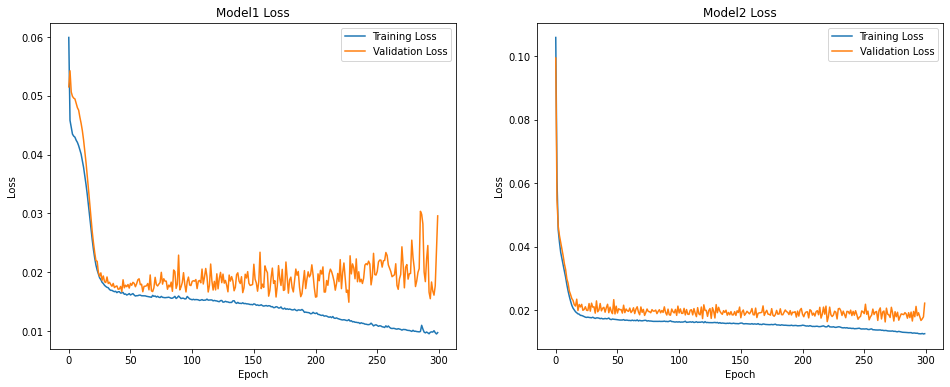

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.2)
for i, (name, model) in enumerate(models.items()):
    ax[i].set_title(f"{name} Loss")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].plot(range(len(result[name][f"Training Loss"])), result[name][f"Training Loss"], label=f"Training Loss")
    ax[i].plot(range(len(result[name][f"Validation Loss"])),  result[name][f"Validation Loss"], label=f"Validation Loss")
    ax[i].legend()
plt.show()

#### 2.5 From the observation of the previous question, please determine an appropriate epoch and retrain the two models to avoid overfitting. Also, draw the loss plot of two models and save the last model as ***model1.pth*** and ***model2.pth***. (10%)
##### (Note. You should reload the models and the optimizer, otherwise, you will resume from the previous stop.)

In [ ]:
models = {"Model1" : MLP(input_ch=8, first_layers=256, second_layers=64, third_layers=8, activation=nn.Tanh(), output_act = nn.Tanh()), 
            "Model2" : MLP(input_ch=8, first_layers=64, second_layers=16, third_layers=8, activation=nn.Tanh(), output_act = nn.Identity())}
learning_rate = 0.01
criterion = nn.MSELoss()
max_epoch = 50
result = {}

for name, model in models.items():
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    pbar = tqdm(range(max_epoch))
    result[name] = {"Training Loss":[], "Validation Loss":[]}
    for i in pbar:
        training_loss = 0
        val_loss = 0
        for inputs, label in train_dl:
            optimizer.zero_grad()
            pred = model(inputs)
            loss = criterion(pred, label)
            loss.backward()
            optimizer.step()
            training_loss+=loss.detach().numpy()

        for inputs, label in val_dl:
            with torch.no_grad():
                pred = model(inputs)
                loss = criterion(pred, label)
                val_loss+=loss.numpy()
        result[name]["Training Loss"].append(training_loss/len(train_dl))
        result[name]["Validation Loss"].append(val_loss/len(val_dl)) 
        
    torch.save(model.state_dict(), f"{name}.pth")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

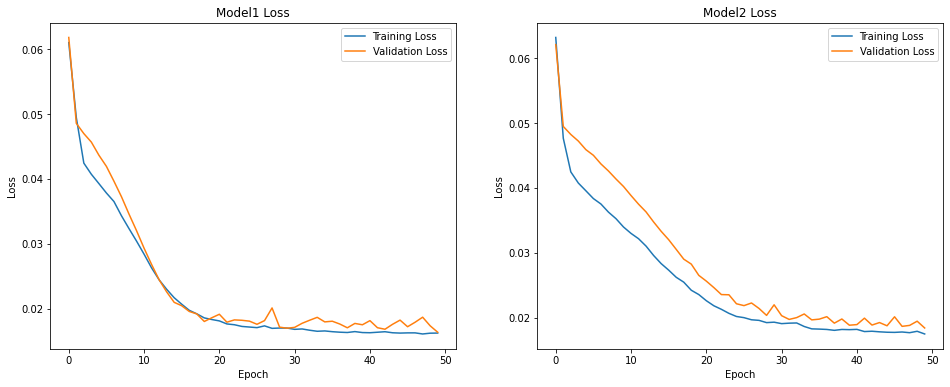

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.2)
for i, (name, model) in enumerate(models.items()):
    ax[i].set_title(f"{name} Loss")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].plot(range(len(result[name][f"Training Loss"])), result[name][f"Training Loss"], label=f"Training Loss")
    ax[i].plot(range(len(result[name][f"Validation Loss"])),  result[name][f"Validation Loss"], label=f"Validation Loss")
    ax[i].legend()
plt.show()

#### 2.6 Please load the checkpoints saved from previous question and calculate the mean squared error on test dataset for two models respectively. Also, make a dataframe with target and prediction like below and save it as ***regression.csv*** (5%)
|Target|Model1|Model2|
|:---:|:---:|:---:|
|24.05|26.35|27.04|
|21.67|32.78|21.95|

In [ ]:
from sklearn.metrics import mean_squared_error
models = {"Model1" : MLP(input_ch=8, first_layers=256, second_layers=64, third_layers=8, activation=nn.Tanh(), output_act = nn.Tanh()), 
            "Model2" : MLP(input_ch=8, first_layers=64, second_layers=16, third_layers=8, activation=nn.Tanh(), output_act = nn.Identity())}
test_ds = ConcreteDataset("/content/gdrive/My Drive/Colab Notebooks/TKU_talk/data/test.csv")
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False) # batch_size=len(test_ds) feeds all testing samples in one batch
output = {}
for name, model in models.items():
    for X, y in test_dl:
        model.load_state_dict(torch.load(f"{name}.pth"))
        model.eval()
        with torch.no_grad():
            pred = model(X)
            output["Target"] = test_ds.y_scaler.inverse_transform(y).squeeze()
            output[name] = test_ds.y_scaler.inverse_transform(pred).squeeze()
        print(f"Mean Squared Error ({name}): ", mean_squared_error(output["Target"], output[name]))

Mean Squared Error (Model1):  102.49895734254744
Mean Squared Error (Model2):  115.87375572334807


In [ ]:
out = pd.DataFrame(output)

In [ ]:
out.to_csv("regression.csv")